In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# install requirements
!pip install segmentation-models==1.0.1 #https://github.com/qubvel/segmentation_models

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
SEED = 123
N_CLASSES = 8
BATCH_SIZE = 8
IMAGE_SIZE=(320,480)
LR = 1e-4
EPOCHS = 1
ACTIVATION = 'sigmoid' if N_CLASSES == 1 else 'softmax'
UNET_BACKBONE='resnet18'

## Data

For this example we will use the **CamVid** dataset. 
The image size in the dataset is 320 x 480 pixels (height x width).
For more information about the dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [5]:
DATA_DIR = './data/CamVid/'

# clone the repository with dataset if it does not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...', end=" ")
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('done!')

In [6]:
# define the dataset paths
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [7]:
def paths_to_dataframe(x_dir, y_dir):
    x_df = pd.DataFrame({'image_fn':[str(f) for f in Path(x_dir).glob("*.png")]})
    x_df['image_id'] = x_df.image_fn.apply(lambda x: Path(x).stem)
    y_df = pd.DataFrame({'mask_fn':[str(f) for f in Path(y_dir).glob("*.png")]})
    y_df['image_id'] = y_df.mask_fn.apply(lambda x: Path(x).stem)
    data_df = x_df.merge(y_df)
    return data_df

In [8]:
# data into dataframes
train_df = paths_to_dataframe(x_train_dir, y_train_dir)
valid_df = paths_to_dataframe(x_valid_dir, y_valid_dir)
test_df = paths_to_dataframe(x_test_dir, y_test_dir)

In [9]:
train_df.head()

,image_fn,image_id,mask_fn
0,data/CamVid/train/0016E5_00540.png,0016E5_00540,data/CamVid/trainannot/0016E5_00540.png
1,data/CamVid/train/0006R0_f02460.png,0006R0_f02460,data/CamVid/trainannot/0006R0_f02460.png
2,data/CamVid/train/0006R0_f02010.png,0006R0_f02010,data/CamVid/trainannot/0006R0_f02010.png
3,data/CamVid/train/0016E5_08460.png,0016E5_08460,data/CamVid/trainannot/0016E5_08460.png
4,data/CamVid/train/0016E5_04440.png,0016E5_04440,data/CamVid/trainannot/0016E5_04440.png


## Segmentation model

In [10]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [11]:
# build the model
preprocess_input = sm.get_preprocessing(UNET_BACKBONE)
model = sm.Unet(UNET_BACKBONE,
                classes=N_CLASSES+1 if N_CLASSES>1 else 1, 
                activation=ACTIVATION,
                encoder_freeze=True
               )

In [12]:
optimizer = tf.keras.optimizers.Adam(LR)
loss = sm.losses.categorical_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optimizer, loss, metrics)

In [13]:
#model.summary()

## Datagenerators

In [14]:
try:
    from ImageDataAugmentor.image_data_augmentor import *
except:
    import sys
    sys.path.append("..")
    from ImageDataAugmentor.image_data_augmentor import *

In [15]:
# datagenerators
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(),
    albumentations.VerticalFlip(),
])

In [16]:
# we will want to one-hot-encode the target masks for segmentation
def one_hot_encode_masks(y:np.array, classes=range(N_CLASSES)):
    y = y.squeeze()
    masks = [(y == v) for v in classes]
    mask = np.stack(masks, axis=-1).astype('float')
    # add background if the mask is not binary
    if mask.shape[-1] != 1:
        background = 1 - mask.sum(axis=-1, keepdims=True)
        mask = np.concatenate((mask, background), axis=-1)
    return mask

In [17]:
dg = ImageDataAugmentor(augment=AUGMENTATIONS, 
                        label_augment_mode="mask", 
                        preprocess_input=preprocess_input,
                        preprocess_labels=one_hot_encode_masks, 
                        seed=SEED
                       )
training_generator = dg.flow_from_dataframe(train_df, 
                                            x_col='image_fn',
                                            y_col='mask_fn', 
                                            class_mode='grayscale_target', #<- reads targets from `mask_fn` col as grayscale
                                            batch_size=BATCH_SIZE, 
                                            target_size=IMAGE_SIZE,
                                            shuffle=True
                                           )
validation_generator = dg.flow_from_dataframe(valid_df, 
                                              x_col='image_fn',
                                              y_col='mask_fn',
                                              class_mode='grayscale_target', #<- reads targets from `mask_fn` col as grayscale
                                              batch_size=BATCH_SIZE, 
                                              target_size=IMAGE_SIZE,
                                              shuffle=True
                                             )

Found 367 validated image filenames.
Found 101 validated image filenames.


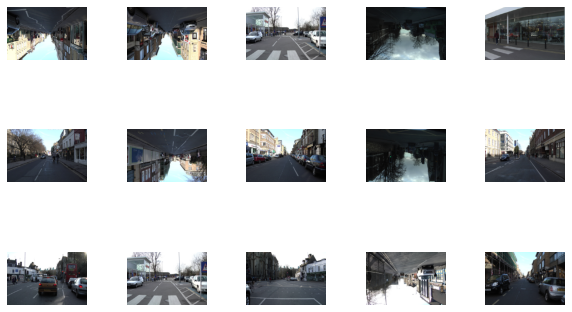

In [18]:
# visualize augmented images
training_generator.show_data(rows=3, cols=5)

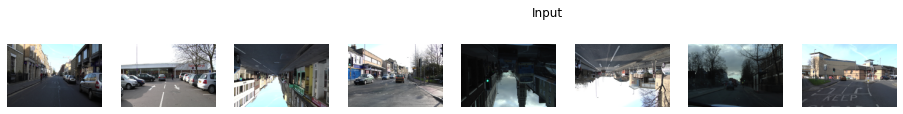

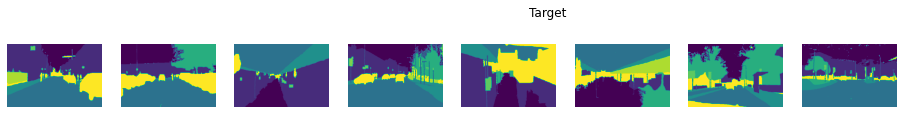

In [19]:
# show inputs and targets
imgs, targets = training_generator.__getitem__(0)

rows, cols = 1, 10
plt.figure(figsize=(2*cols, 2*rows))
for i, img in enumerate(imgs):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.uint8(img))
    plt.axis('off')
plt.suptitle('Input')
plt.show()

plt.figure(figsize=(2*cols, 2*rows))
for i, target in enumerate(targets):
    plt.subplot(rows, cols, i+1)
    plt.imshow(target.argmax(-1))
    plt.axis('off')
plt.suptitle('Target')
plt.show()

## Training

In [20]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_chkp.h5', save_weights_only=True, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [21]:
def plot_training_statistics(history,):
    epochs = [i for i in range(1, len(history['loss'])+1)]

    plt.figure(figsize=(16,6))
    keys = history.keys()
    keys = [key for key in keys if not "lr" in key and not "val_" in key]
    
    for idx, key in enumerate(keys):
        plt.subplot(1, len(keys), idx+1)
        plt.plot(epochs, history[key], label="training_"+key)
        plt.plot(epochs, history['val_'+key], label="validation_"+key)
        plt.legend(loc='best')
        plt.title(key)
        plt.xlabel('epoch')
        
    plt.show()
    plt.close('all')

46/46 [==============================] - 191s 4s/step - loss: 0.8332 - iou_score: 0.1161 - f1-score: 0.1590 - val_loss: 0.8468 - val_iou_score: 0.1340 - val_f1-score: 0.1891 - lr: 1.0000e-04


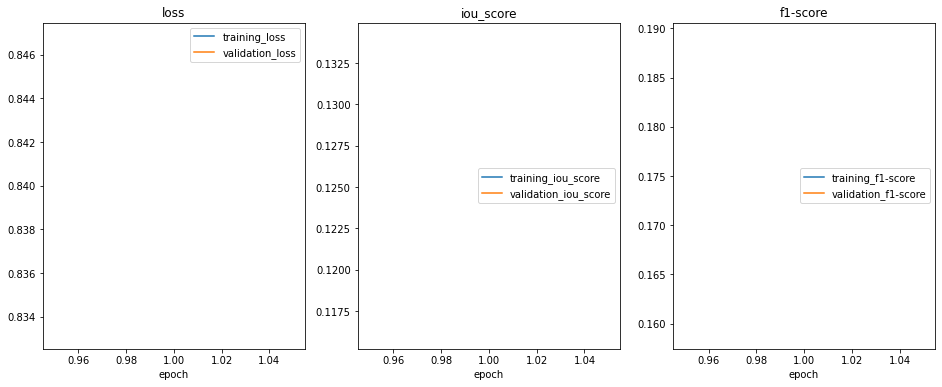

In [22]:
# train model
# this will only train the decoder of the Unet, since we above set `encoder_freeze=True`
history = model.fit(
    training_generator, 
    steps_per_epoch=len(training_generator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=validation_generator, 
    validation_steps=len(validation_generator),
)
plot_training_statistics(history.history)

In [23]:
## uncomment this to continue finetuning all layers of the model
# sm.utils.set_trainable(model)
# ft_history = model.fit(
#     training_generator, 
#     steps_per_epoch=len(training_generator), 
#     epochs=EPOCHS, 
#     callbacks=callbacks, 
#     validation_data=validation_generator, 
#     validation_steps=len(validation_generator),
# )

## Inference

In [24]:
# load the best weights
try:
    model.load_weights("./best_chkp.h5")
except Exception as e:
    print(e)
    pass

In [25]:
# define the test generator
test_dg = ImageDataAugmentor(augment=None, 
                             label_augment_mode="mask", 
                             preprocess_input=preprocess_input,
                             preprocess_labels=one_hot_encode_masks, 
                             seed=SEED
                            )
test_generator = test_dg.flow_from_dataframe(test_df, 
                                             x_col='image_fn',
                                             y_col='mask_fn',
                                             class_mode='grayscale_target', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=IMAGE_SIZE,
                                             shuffle=True
                                            )

Found 233 validated image filenames.


1/1 [==============================] - 1s 942ms/step


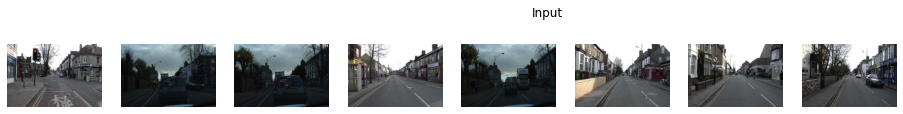

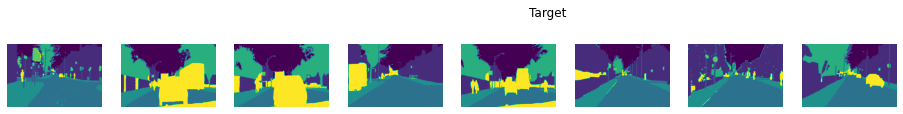

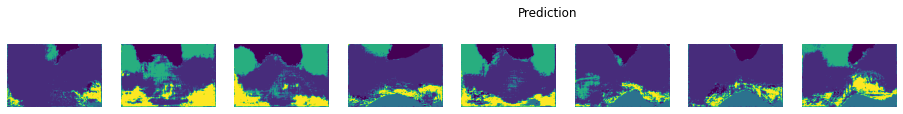

In [26]:
# visualize inputs, targets and preds
imgs, targets = test_generator.__getitem__(0)
preds = model.predict(imgs)

rows, cols = 1, 10
plt.figure(figsize=(2*cols, 2*rows))
for i, img in enumerate(imgs):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.uint8(img))
    plt.axis('off')
plt.suptitle('Input')
plt.show()

plt.figure(figsize=(2*cols, 2*rows))
for i, target in enumerate(targets):
    plt.subplot(rows, cols, i+1)
    plt.imshow(target.argmax(-1))
    plt.axis('off')
plt.suptitle('Target')
plt.show()

plt.figure(figsize=(2*cols, 2*rows))
for i, pred in enumerate(preds):
    plt.subplot(rows, cols, i+1)
    plt.imshow(pred.argmax(-1))
    plt.axis('off')
plt.suptitle('Prediction')
plt.show()

In [28]:
# evaluate the model
scores = model.evaluate(test_generator)

print("loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))